# Model uczenia maszynowego analizujący ryzyko kredytowe

In [94]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Bidirectional, MaxPooling1D, Embedding, BatchNormalization, Reshape, Flatten
from tensorflow.keras import regularizers, Input

## Pobieranie danych

In [46]:
data = None
with open("loan_approval_dataset.json", "r") as file_data:
    data = json.loads(file_data.read())

df_data = pd.DataFrame.from_dict(data)
df_data

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,West_Bengal,6,11,0
251996,251997,2843572,26,10,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,6,11,0
251997,251998,4522448,46,7,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,7,12,0
251998,251999,6507128,45,0,single,rented,no,Graphic_Designer,Pondicherry,Puducherry,0,10,0


In [47]:
df_data.set_index("Id", inplace=True)

## Zrozumienie danych

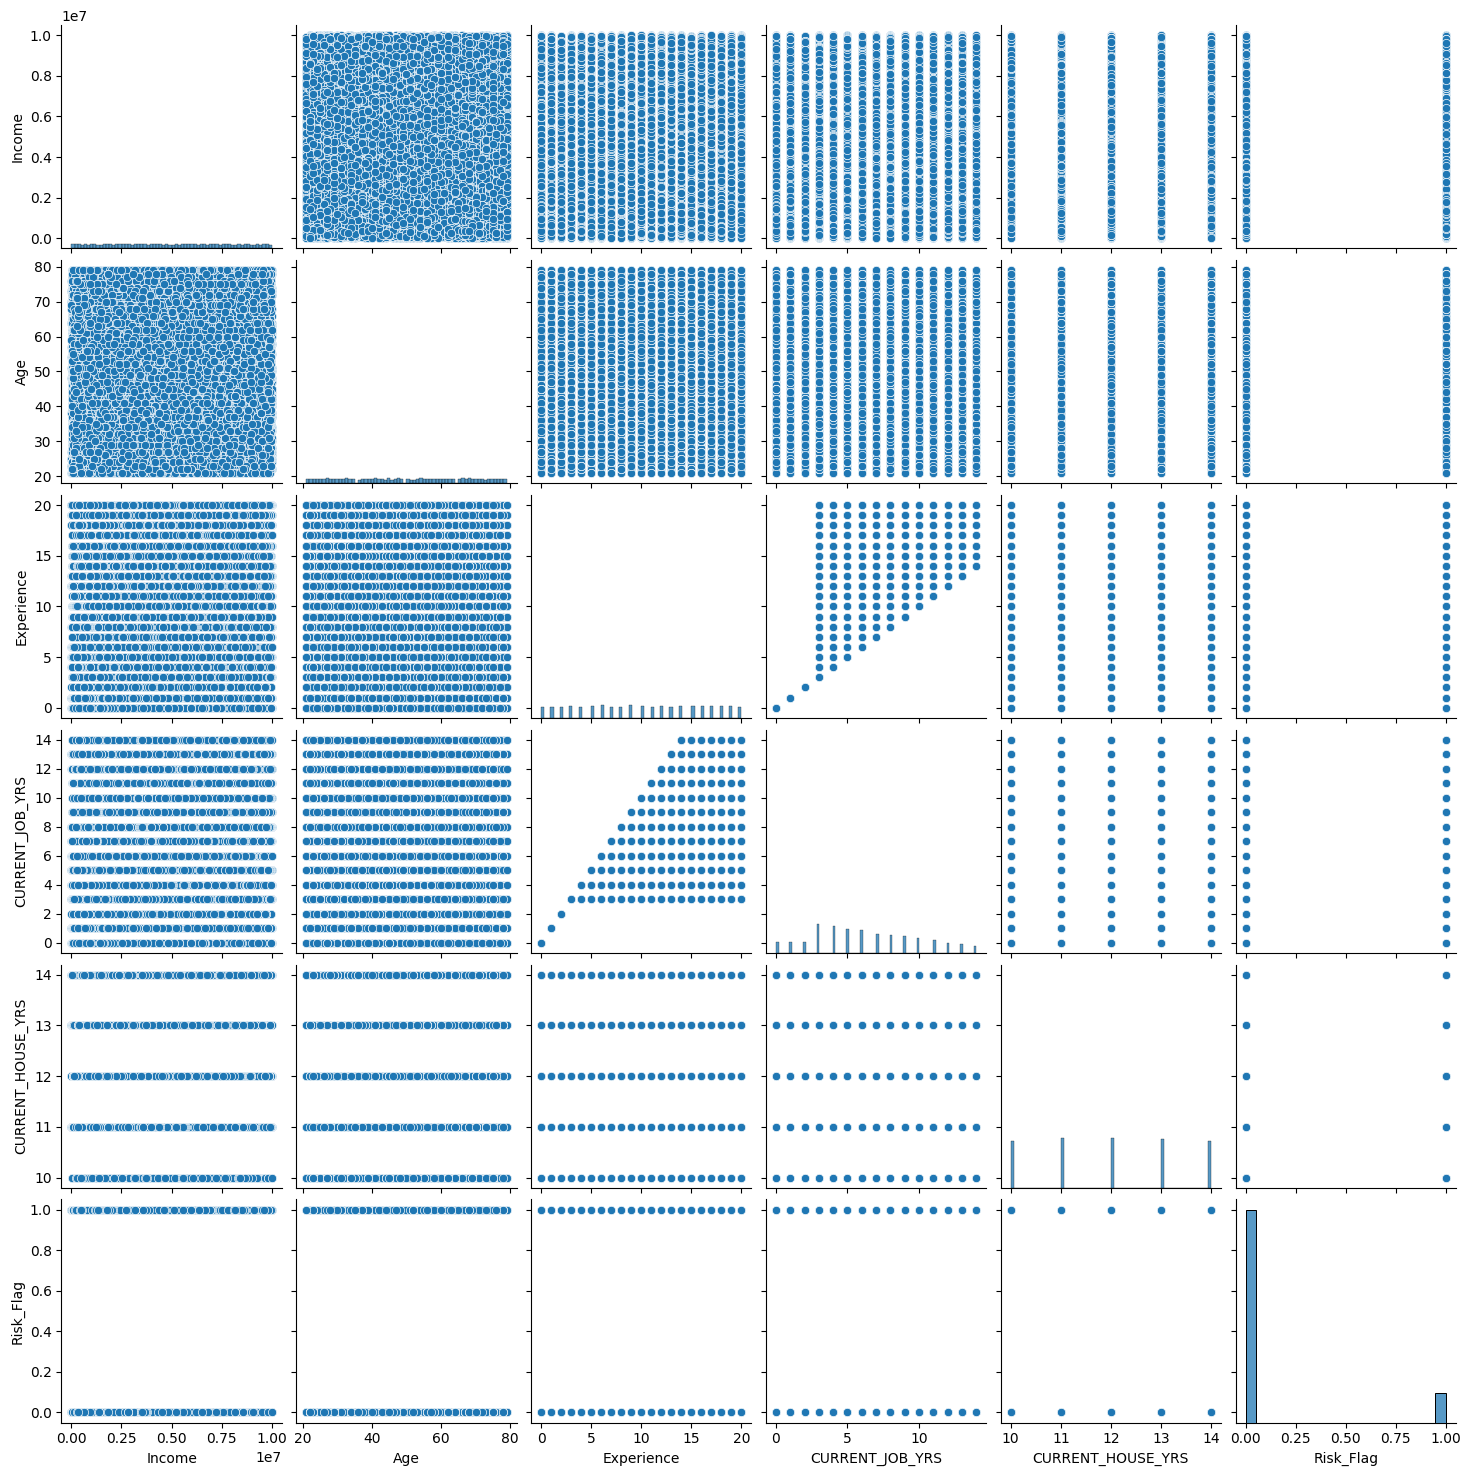

In [48]:
sns.pairplot(df_data)

zrozumienie wartości występujących w danych

In [49]:
print(df_data["Married/Single"].unique())
print(len(df_data["CITY"].unique()))
print(len(df_data["Profession"].unique()))
print(df_data["House_Ownership"].unique())
print(len(df_data["STATE"].unique()))

['single' 'married']
317
51
['rented' 'norent_noown' 'owned']
29


In [50]:
print(df_data.isnull().sum())
print(df_data["CITY"].value_counts())
print("Experience")
print(df_data["Experience"].max())
print(df_data["Experience"].min())
print("Age")
print(df_data["Age"].max())
print(df_data["Age"].min())
print("CURRENT_HOUSE_YRS")
print(df_data["CURRENT_HOUSE_YRS"].max())
print(df_data["CURRENT_HOUSE_YRS"].min())
print(df_data["CURRENT_HOUSE_YRS"].value_counts())
print("CURRENT_JOB_YRS")
print(df_data["CURRENT_JOB_YRS"].max())
print(df_data["CURRENT_JOB_YRS"].min())
print("Income")
print(df_data["Income"].max())
print(df_data["Income"].min())
print(df_data["Income"].mean())

Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64
CITY
Vijayanagaram       1259
Bhopal              1208
Bulandshahr         1185
Saharsa[29]         1180
Vijayawada          1172
                    ... 
Ujjain               486
Warangal[11][12]     459
Bettiah[33]          457
Katni                448
Karaikudi            431
Name: count, Length: 317, dtype: int64
Experience
20
0
Age
79
21
CURRENT_HOUSE_YRS
14
10
CURRENT_HOUSE_YRS
11    51873
12    51791
13    50659
14    49003
10    48674
Name: count, dtype: int64
CURRENT_JOB_YRS
14
0
Income
9999938
10310
4997116.665325397


binning

In [51]:
df_data["Experience_bins"] = pd.cut(df_data['Experience'],bins=[-1,3,6,9,12,15,25], labels=['trainee', 'junior', 'mid', 'advanced','senior','partner'])
df_data["Age_bins"] = pd.cut(df_data['Age'],bins=[20,26,30,40,50,60,70,80], labels=['student', 'young_adult', 'thirties', 'fourties','fifties','sixties','seventies'])
df_data["CURRENT_JOB_YRS_bins"] = pd.cut(df_data['CURRENT_JOB_YRS'],bins=[-1,4,8,12,16], labels=['started', 'short', 'medium', 'long'])
# CURRENT_HOUSE_YRS has only 5 distinct values, so no need for binning
df_data["Income_bins"] = pd.cut(df_data['Income'],bins=[0,125000,500000,3000000,10000000], labels=['destitute', 'aspirer', 'middle_class', 'rich'])

todo

In [52]:
print(df_data["Income_bins"].value_counts())
#Todo: test - log normalize Income to get more even distribution and bin based on quantiles?
#df_data["Income"]


Income_bins
rich            175999
middle_class     63316
aspirer           9961
destitute         2724
Name: count, dtype: int64


In [53]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 1 to 252000
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Income                252000 non-null  int64   
 1   Age                   252000 non-null  int64   
 2   Experience            252000 non-null  int64   
 3   Married/Single        252000 non-null  object  
 4   House_Ownership       252000 non-null  object  
 5   Car_Ownership         252000 non-null  object  
 6   Profession            252000 non-null  object  
 7   CITY                  252000 non-null  object  
 8   STATE                 252000 non-null  object  
 9   CURRENT_JOB_YRS       252000 non-null  int64   
 10  CURRENT_HOUSE_YRS     252000 non-null  int64   
 11  Risk_Flag             252000 non-null  int64   
 12  Experience_bins       252000 non-null  category
 13  Age_bins              252000 non-null  category
 14  CURRENT_JOB_YRS_bins  252000 non-null  ca

przygotowanie danych do treningu

In [54]:
df_prepared = pd.get_dummies(df_data, 
                             columns=['Experience_bins', 'Age_bins', 'CURRENT_JOB_YRS_bins', 'Income_bins', 
                                      'CURRENT_HOUSE_YRS', 'Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
                                      'CITY', 'STATE'], 
                             prefix=['Experience_bins', 'Age_bins', 'CURRENT_JOB_YRS_bins', 'Income_bins', 
                                      'CURRENT_HOUSE_YRS', 'Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
                                      'CITY', 'STATE'],
                             dtype=int)
df_prepared = df_prepared.drop(['Experience', 'Age', 'CURRENT_JOB_YRS', 'Income'], axis=1)
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 1 to 252000
Columns: 431 entries, Risk_Flag to STATE_West_Bengal
dtypes: int32(430), int64(1)
memory usage: 417.2 MB


przygotowanie wybranych danych do narysowania wykresu korelacji

In [55]:
df_prepared_2 = pd.get_dummies(df_data, 
                             columns=['Experience_bins', 'Age_bins', 'CURRENT_JOB_YRS_bins', 'Income_bins', 
                                      'CURRENT_HOUSE_YRS', 'Married/Single', 'House_Ownership', 'Car_Ownership'], 
                             prefix=['Experience_bins', 'Age_bins', 'CURRENT_JOB_YRS_bins', 'Income_bins', 
                                      'CURRENT_HOUSE_YRS', 'Married/Single', 'House_Ownership', 'Car_Ownership'],
                             dtype=int)
df_prepared_2 = df_prepared_2.drop(['Experience', 'Age', 'CURRENT_JOB_YRS', 'Income', 'CITY', 'STATE', 'Profession'], axis=1)
df_prepared_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 1 to 252000
Data columns (total 34 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   Risk_Flag                     252000 non-null  int64
 1   Experience_bins_trainee       252000 non-null  int32
 2   Experience_bins_junior        252000 non-null  int32
 3   Experience_bins_mid           252000 non-null  int32
 4   Experience_bins_advanced      252000 non-null  int32
 5   Experience_bins_senior        252000 non-null  int32
 6   Experience_bins_partner       252000 non-null  int32
 7   Age_bins_student              252000 non-null  int32
 8   Age_bins_young_adult          252000 non-null  int32
 9   Age_bins_thirties             252000 non-null  int32
 10  Age_bins_fourties             252000 non-null  int32
 11  Age_bins_fifties              252000 non-null  int32
 12  Age_bins_sixties              252000 non-null  int32
 13  Age_bins_seventies 

wykres korelacji

<Axes: >

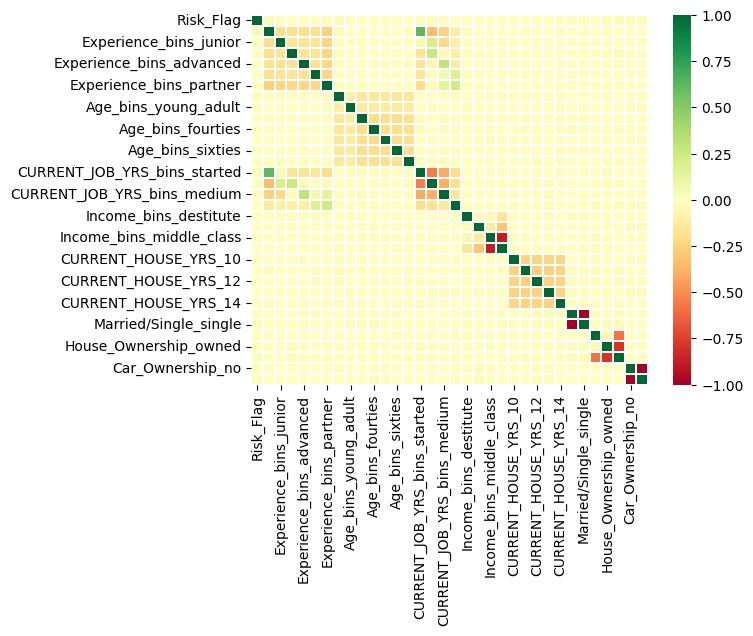

In [56]:
sns.heatmap(df_prepared_2.corr(), cmap='RdYlGn', linewidth=0.2)

## Przygotowanie zbiorów testowych i treningowych

## Podział danych ze względu na przychód

Podział ponieważ jest nierówny rozkład danych

In [134]:
aspirer_data = df_prepared[df_prepared["Income_bins_aspirer"] == 1].copy()
destitute_data = df_prepared[df_prepared["Income_bins_destitute"] == 1].copy()
middle_class_data = df_prepared[df_prepared["Income_bins_middle_class"] == 1].copy()
rich_data = df_prepared[df_prepared["Income_bins_rich"] == 1].copy()

income_separated_data = [aspirer_data, destitute_data, middle_class_data, rich_data]
for i in income_separated_data:
    i.drop(["Income_bins_aspirer", "Income_bins_destitute", "Income_bins_middle_class", "Income_bins_rich"], axis=1, inplace=True)

In [122]:
def getTrainTestData(data):
    train, test = train_test_split(data, test_size=0.2)
    test_y = test["Risk_Flag"]
    test_x = test.drop("Risk_Flag", axis=1)

    train_y = train["Risk_Flag"]
    train_x = train.drop("Risk_Flag", axis=1)
    return (train_x, train_y, test_x, test_y)

In [124]:
(train_x, train_y, test_x, test_y) = getTrainTestData(df_prepared)

# (aspirer_train_x, aspirer_train_y, aspirer_test_x, aspirer_test_y) = getTrainTestData(aspirer_data)
# (destitute_train_x, destitute_train_y, destitute_test_x, destitute_test_y) = getTrainTestData(destitute_data)
# (middle_class_train_x, middle_class_train_y, middle_class_test_x, middle_class_test_y) = getTrainTestData(middle_class_data)
# (rich_train_x, rich_train_y, rich_test_x, rich_test_y) = getTrainTestData(rich_data)

In [57]:
# train, test = train_test_split(df_prepared, test_size=0.2)

In [58]:
# test_y = test["Risk_Flag"]
# test_x = test.drop("Risk_Flag", axis=1)

# train_y = train["Risk_Flag"]
# train_x = train.drop("Risk_Flag", axis=1)

# Tworzenie modelu

In [125]:
model=Sequential([
    Input(shape=(train_x.shape[1],)),
    Reshape((43,10)),
    Bidirectional(GRU(10)),
    Embedding(20, 10),
    MaxPooling1D(pool_size=4, strides=2, padding="valid"),
    Flatten(),
    Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
  ])
model.summary()

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_38 (Reshape)            │ (None, 43, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_40                │ (None, 20)             │         1,320 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_42 (Embedding)        │ (None, 20, 10)         │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 9, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 100)            │         9,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,721 (61.41 KB)

 Trainable params: 15,721 (61.41 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

In [127]:
hisotry = model.fit(train_x, train_y, epochs=30, batch_size=30000, validation_split=0.2)

Epoch 1/30


f:\Studia\Machine Learning\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.8563 - loss: 1.3590 - val_accuracy: 0.8774 - val_loss: 1.0823
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8769 - loss: 1.0751 - val_accuracy: 0.8774 - val_loss: 1.0161
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8773 - loss: 1.0100 - val_accuracy: 0.8774 - val_loss: 0.9590
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8772 - loss: 0.9528 - val_accuracy: 0.8774 - val_loss: 0.9061
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8769 - loss: 0.9020 - val_accuracy: 0.8774 - val_loss: 0.8571
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8783 - loss: 0.8514 - val_accuracy: 0.8774 - val_loss: 0.8115
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8770 - loss: 0.8079 - val_accuracy: 0.8774 - val_loss: 0.7686
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8780 - loss: 0.7640 - val_accuracy: 0.8774 - val_loss: 0.7290
Epo

In [129]:
model.evaluate(test_x, test_y)

1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8731 - loss: 0.3966


[0.39253002405166626, 0.8751785755157471]

## Model z podziałem na klasy przychodu

In [139]:
def getIncomeModel():
  model=Sequential([
      Input(shape=(426,)),
      Reshape((71,6)),
      Bidirectional(GRU(10)),
      Embedding(20, 10),
      MaxPooling1D(pool_size=4, strides=2, padding="valid"),
      Flatten(),
      Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
      Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
      Dropout(0.25),
      Dense(1, activation='sigmoid')
    ])
  #model.summary()
  model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [141]:
for data in income_separated_data:
    (class_train_x, class_train_y, class_test_x, class_test_y) = getTrainTestData(data)
    batch_size = int(len(data.index)/10)
    # class_train_y.info()
    # class_train_x.info()
    model = getIncomeModel()
    hisotry = model.fit(class_train_x, class_train_y, epochs=30, batch_size=batch_size, validation_split=0.2)
    print("--------Results---------")
    model.evaluate(class_test_x, class_test_y)
    print("--------Results---------")

Epoch 1/30


f:\Studia\Machine Learning\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6231 - loss: 1.3853 - val_accuracy: 0.8639 - val_loss: 1.0987
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8655 - loss: 1.0828 - val_accuracy: 0.8639 - val_loss: 1.0231
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8674 - loss: 1.0064 - val_accuracy: 0.8639 - val_loss: 0.9587
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8670 - loss: 0.9440 - val_accuracy: 0.8639 - val_loss: 0.9008
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8666 - loss: 0.8881 - val_accuracy: 0.8639 - val_loss: 0.8455
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8624 - loss: 0.8409 - val_accuracy: 0.8639 - val_loss: 0.7962
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8652 - loss: 0.7884 - val_accuracy: 0.8639 - val_loss: 0.7496
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8694 - loss: 0.7341 - val_accuracy: 0.8639 - val_loss: 0.7089
Epoch 9/30


f:\Studia\Machine Learning\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6344 - loss: 1.4373 - val_accuracy: 0.8142 - val_loss: 1.2320
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8337 - loss: 1.1730 - val_accuracy: 0.8142 - val_loss: 1.1058
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8449 - loss: 1.0518 - val_accuracy: 0.8142 - val_loss: 1.0392
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8525 - loss: 0.9698 - val_accuracy: 0.8142 - val_loss: 0.9794
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8384 - loss: 0.9356 - val_accuracy: 0.8142 - val_loss: 0.9315
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8462 - loss: 0.8708 - val_accuracy: 0.8142 - val_loss: 0.8791
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8364 - loss: 0.8346 - val_accuracy: 0.8142 - val_loss: 0.8415
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8412 - loss: 0.7918 - val_accuracy: 0.8142 - val_loss: 0.7932
Epoch 9/30
7/7 ━━━

f:\Studia\Machine Learning\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5918 - loss: 1.3812 - val_accuracy: 0.8811 - val_loss: 1.0804
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8782 - loss: 1.0750 - val_accuracy: 0.8811 - val_loss: 1.0119
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8796 - loss: 1.0047 - val_accuracy: 0.8811 - val_loss: 0.9491
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8781 - loss: 0.9474 - val_accuracy: 0.8811 - val_loss: 0.8909
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8760 - loss: 0.8937 - val_accuracy: 0.8811 - val_loss: 0.8369
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8788 - loss: 0.8339 - val_accuracy: 0.8811 - val_loss: 0.7852
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8779 - loss: 0.7853 - val_accuracy: 0.8811 - val_loss: 0.7371
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8775 - loss: 0.7386 - val_accuracy: 0.8811 - val_loss: 0.6949
Epoch 9/30


f:\Studia\Machine Learning\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias', 'kernel', 'recurrent_kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.7938 - loss: 1.3447 - val_accuracy: 0.8764 - val_loss: 1.0737
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8781 - loss: 1.0656 - val_accuracy: 0.8764 - val_loss: 1.0014
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8791 - loss: 0.9919 - val_accuracy: 0.8764 - val_loss: 0.9387
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8781 - loss: 0.9299 - val_accuracy: 0.8764 - val_loss: 0.8803
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8784 - loss: 0.8715 - val_accuracy: 0.8764 - val_loss: 0.8263
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8781 - loss: 0.8178 - val_accuracy: 0.8764 - val_loss: 0.7767
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8788 - loss: 0.7670 - val_accuracy: 0.8764 - val_loss: 0.7300
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8778 - loss: 0.7232 - val_accuracy: 0.8764 - val_loss: 0.6870
Epoch 9/30

# Podsumowanie

Model radzi sobie w miarę dobrze, jednak dostrojenie go do uzyskania lepszych wyników prawdopodobnie wymagałoby zmiany sposobu przygotowania danych lub nawet pozyskania lepszej jakości danych. Moje próby zmiany warstw głębokich i dostrojenia hiperparametrów nie przyniosły żadnych efektów w postaci wyższej dokładności, model z warstwami gęstymi radził sobie równie dobrze.